# Predicting The Stock Market

We'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index goes up or down helps forecast how the stock market as a whole performs. Since stocks tend to correlate with how well the economy as a whole is performs, it can also help with economic forecasts.

There are thousands of traders who make money by buying and selling Exchange Traded Funds. ETFs allow you to buy and sell indexes like stocks. This means that you could "buy" the S&P500 Index ETF when the price is low and sell when it's high to make a profit. Creating a predictive model could allow traders to make money on the stock market.

Note: You shouldn't make trades with any models developed in this lesson. Trading stocks has risks and nothing in this lesson constitutes stock trading advice.

I repeat, this is not financial advice.

We will start by importing some needed libraries, reading into python the dataset we will use, and checking it out.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
df = pd.read_csv('sphist.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [55]:
# we need to convert the Date column to a datetime format

df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       16590 non-null  datetime64[ns]
 1   Open       16590 non-null  float64       
 2   High       16590 non-null  float64       
 3   Low        16590 non-null  float64       
 4   Close      16590 non-null  float64       
 5   Volume     16590 non-null  float64       
 6   Adj Close  16590 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.4 KB


In [56]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


Let's also import the datetime function, which allows us to make date comparisons.

In [57]:
from datetime import datetime
df["Date"] > datetime(year=2015, month=4, day=1)

0         True
1         True
2         True
3         True
4         True
         ...  
16585    False
16586    False
16587    False
16588    False
16589    False
Name: Date, Length: 16590, dtype: bool

In [58]:
df.sort_values(['Date'], ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


Datasets taken from the stock market need to be handled differently than datasets from other sectors when it's time to make predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential and each observation comes a day after the previous observation. Thus, the observations are not all independent and you can't treat them as such.

This means you have to be extra careful not to inject "future" knowledge into past rows when you train and predict. Injecting future knowledge makes our model look good when we train and test it, but it fails in the real world. This is how many algorithmic traders lose money.

The time series nature of the data means that we can generate indicators to make our model more accurate. For instance, you can create a new column that contains the average price of the last 10 trades for each row. This incorporates information from multiple prior rows into one and makes predictions much more accurate.

When you do this, you have to be careful not to use the current row in the values you average. You want to teach the model how to predict the current price from historical prices. If you include the current price in the prices you average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where you don't know the price upfront.

We will use the following indicators:

- The average price for the past 5 days.
- The standard deviation of the price over the past 5 days.
- The average price for the past 365 days.

Some of these indicators require a year of historical data to compute. Our first day of data falls on 1950-01-03, so the first day we can start computing indicators on is 1951-01-03.

In [85]:
def avg_ndays_stock_price(df, n):
    col_name = 'Avg_' + str(n) + '_days'
    for index, row in df.iterrows():
        start_index = index + n
        if start_index not in df.index:
            df.loc[index, col_name] = 0
        else:
            # assign mean nday to column
            df.loc[index, col_name] = round(df.loc[start_index:(index+1), 'Close'].mean(),3)
    return df

def std_ndays_stock_price(df, n):
    col_name = 'Std_' + str(n) + '_days'
    for index, row in df.iterrows():
        start_index = index + n
        if start_index not in df.index:
            df.loc[index, col_name] = 0
        else:
            # assign standard deviation nday to column
            df.loc[index, col_name] = round(df.loc[start_index:(index+1), 'Close'].std(), 3)
    return df

In [86]:
avg_ndays_stock_price(df, 5)
avg_ndays_stock_price(df, 365)
avg_ndays_stock_price(df, 30)
std_ndays_stock_price(df, 5)
std_ndays_stock_price(df, 30)
df.head(8)

,Date,Open,High,Low,Close,Volume,Adj Close,Avg_5_days,Avg_365_days,Std_5_day,Avg_10_days,Avg_30_days,Std_5_days,Std_30_days
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,0.000,0.0,0.000,0.0,0.0,0.000,0.0
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,0.0,0.158,0.0,0.0,0.158,0.0
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,0.0,0.089,0.0,0.0,0.089,0.0
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,0.0,0.068,0.0,0.0,0.068,0.0


We need to filter out the data for which we won't have any data available (Our first day of data falls on 1950-01-03, so the first day we can start computing indicators on is 1951-01-03.)

In [87]:
df_new = df[df["Date"] > datetime(year=1951, month=1, day=2)].copy()
df_new.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Avg_5_days,Avg_365_days,Std_5_day,Avg_10_days,Avg_30_days,Std_5_days,Std_30_days
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,20.360,0.0,0.304,20.163,19.815,0.304,0.404
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.514,0.0,0.205,20.247,19.843,0.205,0.434
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.628,0.0,0.214,20.338,19.874,0.214,0.473
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,20.726,0.0,0.182,20.428,19.907,0.182,0.507
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,20.840,0.0,0.117,20.530,19.935,0.117,0.543


In [88]:
df_new.dropna(axis=0, inplace=True)

In [89]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16340 entries, 16339 to 0
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          16340 non-null  datetime64[ns]
 1   Open          16340 non-null  float64       
 2   High          16340 non-null  float64       
 3   Low           16340 non-null  float64       
 4   Close         16340 non-null  float64       
 5   Volume        16340 non-null  float64       
 6   Adj Close     16340 non-null  float64       
 7   Avg_5_days    16340 non-null  float64       
 8   Avg_365_days  16340 non-null  float64       
 9   Std_5_day     16340 non-null  float64       
 10  Avg_10_days   16340 non-null  float64       
 11  Avg_30_days   16340 non-null  float64       
 12  Std_5_days    16340 non-null  float64       
 13  Std_30_days   16340 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.9 MB


### Train-test split on the dataset based on a date.

In [90]:
train = df_new[df_new["Date"] < datetime(year=2013, month=1, day=1)].copy()
test = df_new[df_new["Date"] >= datetime(year=2013, month=1, day=1)].copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15601 entries, 16339 to 739
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          15601 non-null  datetime64[ns]
 1   Open          15601 non-null  float64       
 2   High          15601 non-null  float64       
 3   Low           15601 non-null  float64       
 4   Close         15601 non-null  float64       
 5   Volume        15601 non-null  float64       
 6   Adj Close     15601 non-null  float64       
 7   Avg_5_days    15601 non-null  float64       
 8   Avg_365_days  15601 non-null  float64       
 9   Std_5_day     15601 non-null  float64       
 10  Avg_10_days   15601 non-null  float64       
 11  Avg_30_days   15601 non-null  float64       
 12  Std_5_days    15601 non-null  float64       
 13  Std_30_days   15601 non-null  float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.8 MB


### Instantiate and fit a Linear Model

In [91]:
# import some sklearn packages 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
lr = LinearRegression()

In [101]:
features = ['Avg_5_days', 'Avg_365_days', 'Std_5_days']
target = 'Close'
lr.fit(train[features], train[target])
predictions = lr.predict(test[features])
mae = mean_absolute_error(predictions, test[target])
print(mae)

16.094060115537875


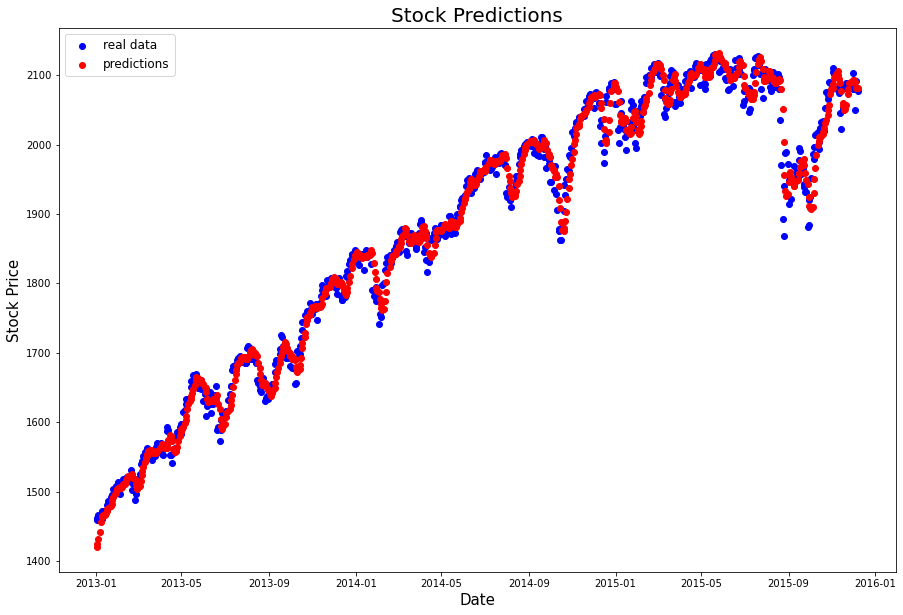

In [109]:
# let's plot the data
plt.figure(figsize=(15,10))
plt.scatter(test['Date'], test['Close'], c='b', label='real data')
plt.scatter(test['Date'], predictions, c='r', label='predictions')
plt.title('Stock Predictions', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.legend(fontsize=12)
plt.show()

Not bad! This seems the best model using only the average closing price and the SD based on the past 5/30/365 days. It might be possible to improve the model by using other information, such as the volume of the past 5/30/365 days.